In [142]:
# Imports 
import numpy as np
import librosa
from matplotlib import pyplot as plt

# Reading Data

### Single file loading

In [143]:
# data/BallroomData/Quickstep/Albums-Ballroom_Classics4-20.wav - 204 BPM 
# data/BallroomData/Quickstep/Albums-Chrisanne2-11.wav - 204 BPM 
# data/BallroomData/Tango/Media-105508.wav - 128 BPM
# data/BallroomData/ChaChaCha/Albums-Cafe_Paradiso-08.wav - Easy 124  - BPM 
# data/BallroomData/Rumba-American/Albums-GloriaEstefan_MiTierra-04.wav - 122 BPM
# data/BallroomData/Waltz/Albums-Ballroom_Classics4-01.wav - Very hard - 87 BPM 
# data/BallroomData/Jive/Albums-Cafe_Paradiso-16.wav # Easy - 172 BPM

# get file
file_path = 'data/BallroomData/Waltz/Albums-Ballroom_Classics4-01.wav'

# resample rate - based on method of ellis 2007
resample_rate = 8000

# load audio
y, sr = librosa.load(file_path, sr=resample_rate)



# Onset Strength Envelope

Calculating a perceptually weighted onset strength envelope.
- Audio resampled to 8 kHz
- Calculate STFT 32ms window, 4ms hop size 
- Mapped to 40 band Mel spectrogram
- Mel converted to dB
- First order difference along time calculated for each band
- Half wave rectification (Negative value set to zero)
- Sum across bands
- High pass filter 0.4 Hz (make it locally zero mean)
- Convolved with Gaussian envelope 20ms wide - I havent done this
- Normalise onset envelope by dividing by musical excerpt standard deviation

This should result in 1D onset envelope strength as a function of time that responds to a proportional increase in energy summed across approximately auditory frequency bands.

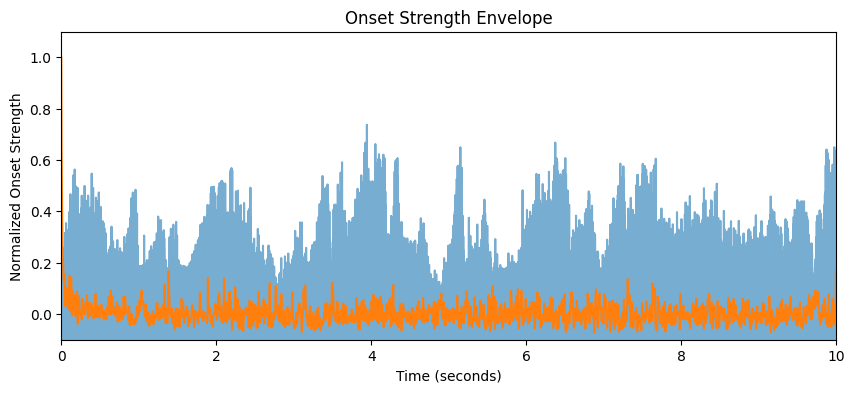

In [144]:
from scipy.signal import butter, filtfilt, lfilter

# butterworth highpass filter
def high_pass_filter(y, sr, cutoff=0.4, order=1):
    """Apply a high-pass filter to the signal."""
    nyquist = 0.5 * sr
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    y_filtered = filtfilt(b, a, y, axis=0)
    return y_filtered

def mel_db(sr, stft, n_fft, hop_length, n_mels=40):
    abs_stft = abs(stft)
    
    # Create a Mel spectrogram with 40 Mel bands
    mel = librosa.feature.melspectrogram(S=abs_stft**2, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)
    
    # Convert power spectrogram (amplitude squared) to dB
    mel_db = librosa.power_to_db(mel)
    
    return mel_db
    
# Onset strength envelope
def onset_strength_envelope(y, sr, window_sec=0.032, hop_sec=0.004, show=True):    
    # Calculate the STFT with a 32ms window and 4ms hop size
    n_fft = int(window_sec * sr)  # Window seconds to samples
    hop_length = int(hop_sec * sr)  # Hop seconds to samples
    stft = librosa.stft(y, n_fft=n_fft, hop_length=hop_length)

    # apply mel scale with 40 bands
    mel = mel_db(sr, stft, n_fft, hop_length)
    
    # apply first order difference
    mel_dif = np.diff(mel, axis=1)
    
    # half wave rectify
    mel_half_rec = np.maximum(0, mel_dif)
    
    # sum across bands
    onset_strength = np.sum(mel_half_rec , axis=0)
    
    # librosa remove DC like this - How do they do this in lab solution?
    onset_strength = lfilter([1.0, -1.0], [1.0, -0.99], onset_strength, axis=-1)
    
    # normalise to standard deviation (add small number to avoid div by 0) 
    # find significant difference from mean   
    onset_strength_norm  = onset_strength / np.std(onset_strength) + 1e-10 
    
    if(show): plot_onset_envelope_strength(y, onset_strength_norm, hop_sec)
        
    return onset_strength_norm

def plot_onset_envelope_strength(y, onset_strength, hop_sec):
    hop_length = int(hop_sec * sr)
    
    # normalise range 0 - 1
    onset_strength = onset_strength / np.max(onset_strength)
    
    # Time vector for plotting
    times = librosa.frames_to_time(np.arange(len(onset_strength)), sr=sr, hop_length=hop_length)
    
    # Plotting
    plt.figure(figsize=(10, 4))
    plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # Plot waveform
    plt.plot(times, onset_strength)
    plt.title('Onset Strength Envelope')
    plt.xlabel('Time (seconds)')
    plt.ylabel('Normalized Onset Strength')
    plt.xlim([0, 10])
    plt.ylim([-0.1, 1.1])
    plt.show()

hop_sec=0.004
ose = onset_strength_envelope(y, sr, hop_sec=hop_sec)




# Global Tempo Estimate

Dynamic programming method dependant on tempo estimate.
- Use autocorrelation on onset strength envelope
- Apply perceptual weighting Gaussian window to raw autocorrelation
    - Gives TPS
    - Using T0 = 0.5 secs omegaT = 1.4 octaves
- Pick largest peak from TPS for tempo estimate

Extension:
Resample TPS to a half and a third, then adding the result to the original signal and picking the largest peak for tempo estimate.
- uses different values for T0 and omegaT

faster_tempo_level: 555.491303298627, slower_tempo_level 411.68038695457926
faster_tempo weigth: 0.5743461154794544, slower_tempo weight 0.4256538845205457
weight ratio: 0.14869223095890866


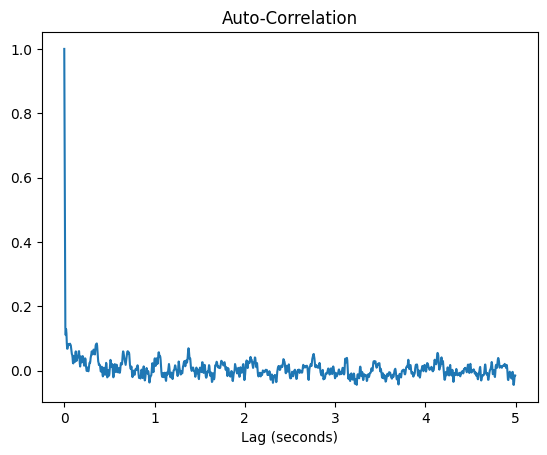

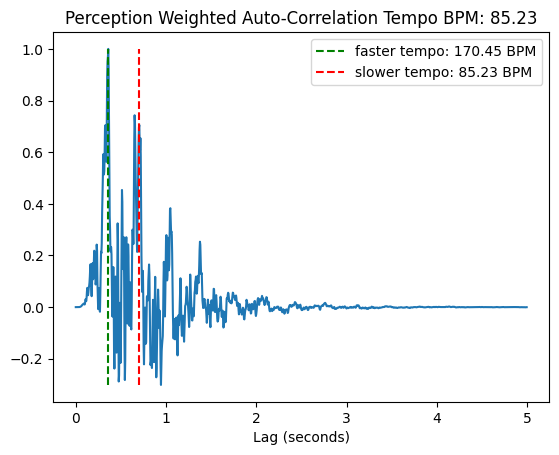

In [145]:

def plot_auto_c(auto_c, tps, faster_tempo, slower_tempo, selected_tempo, sr, hop_length):
    # calculate bpm for plot
    faster_tempo_bpm = round(60 * sr / (faster_tempo * hop_length), 2)
    slower_tempo_bpm = round(60 * sr / (slower_tempo * hop_length), 2)
    selected_tempo_bpm = round(60 * sr / (selected_tempo * hop_length), 2)
    
    auto_c = auto_c / np.max(auto_c)
    tps = tps / np.max(tps)
    
    times = np.arange(len(auto_c)) * (hop_length / sr)

    plt.plot(times, auto_c)
    plt.title('Auto-Correlation')
    plt.xlabel('Lag (seconds)')
    plt.show()

    plt.plot(times, tps)
    plt.vlines(faster_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='g', linestyle='--', label='faster tempo: {} BPM'.format(faster_tempo_bpm))
    plt.vlines(slower_tempo * (hop_length / sr), ymin=min(tps), ymax=max(tps), color='r', linestyle='--', label='slower tempo: {} BPM'.format(slower_tempo_bpm))
    plt.legend()
    plt.title('Perception Weighted Auto-Correlation Tempo BPM: {}'.format(selected_tempo_bpm))
    plt.xlabel('Lag (seconds)')
    plt.show()
    
# Apply perceptual weighting based on tempo tapping data
def perceptual_weighting(t, t0=0.5, sigma_t=0.9): # t0 (bpm) and sigma_t (octaves) values from ellis 2007  
    # avoid div by zero error 
    epsilon = 1e-10
    t = np.maximum(t, epsilon)
    
    log_2_t_over_t0 = np.log2(t / t0)
    
    W_t = np.exp(-0.5 * (log_2_t_over_t0 / sigma_t) ** 2)
    
    return W_t

def secondary_tempo(tps):
    # only search 1/3 of the tps this should be plenty with 5 second tps
    tps_range = round(len(tps) / 3)
    
    tps_2 = np.zeros(tps_range)
    tps_3 = np.zeros(tps_range)

    for t in range(tps_range):
        # equation (7) and (8) - ellis 2007
        tps_2[t] = tps[t] + (0.5 * tps[2 * t]) + (0.25 * tps[(2 * t) - 1]) + (0.25 * tps[(2 * t) + 1])
        tps_3[t] = tps[t] + (0.33 * tps[3 * t]) + (0.33 * tps[(3 * t) - 1]) +(0.33 * tps[(3 * t) + 1])            
        
    duple = np.max(tps_2)
    triple = np.max(tps_3)
     
    # Whichever sequence contains the larger value determines whether the tempo is considered 
    # duple or triple, respectively, and the location of the largest value is treated as the 
    # faster target tempo, with one-half or one-third of that tempo, respectively, as the adjacent 
    # metrical level.   
    
    if duple > triple:
        faster_tempo_frame = np.argmax(tps_2)
        slower_tempo_frame = np.argmax(tps_2) * 2
        return faster_tempo_frame, slower_tempo_frame
    else: 
        faster_tempo_frame = np.argmax(tps_3)
        slower_tempo_frame = np.argmax(tps_3) * 3
        return faster_tempo_frame, slower_tempo_frame
  
def estimate_tempo(odf, sr, hop_sec, max_lag_s=5, weight_threshold_ratio=0.15, show=True):
    hop_length = int(hop_sec * sr)

    # only correlate reasonable tempo range - 4 seconds is plenty
    max_size = max_lag_s * sr / hop_length

    # auto correlate onset strength
    auto_c = librosa.autocorrelate(odf, max_size=max_size)

    # weighting function needs lag in seconds
    lags_seconds = np.arange(len(auto_c)) * (hop_length / sr)

    # apply perceptual weightinig get tempo period strengths
    tps = perceptual_weighting(lags_seconds) * auto_c
    
    # # calculate secondary bpm
    # # two further functions are calculated by resampling T P S to one-half and one-third, 
    # # respectively, of its original length, adding this to the original T P S, 
    # # then choosing the largest peak across both these sequences - ellis 2007
    faster_tempo_frame, slower_tempo_frame = secondary_tempo(tps)
    
    # Relative weights of the two levels are again taken from the relative peak heights 
    # at the two period estimates in the original T P S. This approach finds the tempo that maximizes
    # the sum of the T P S values at both metrical levels
    faster_tempo_level = tps[faster_tempo_frame]
    slower_tempo_level = tps[slower_tempo_frame]
    
    faster_tempo_weight = faster_tempo_level / (faster_tempo_level + slower_tempo_level)
    slower_tempo_weight = slower_tempo_level / (faster_tempo_level + slower_tempo_level)
               
    # start testing without - risk of over fitting to data set
    # weight difference decision rule - not explicitly mentioned in the paper - this is my interpretation 
    
    # weight difference threshold
    if abs(faster_tempo_weight - slower_tempo_weight) > weight_threshold_ratio: selected_tempo = slower_tempo_frame
    else: selected_tempo = faster_tempo_frame
        
    # plot results
    if(show): 
        print("faster_tempo_level: {}, slower_tempo_level {}".format(faster_tempo_level, slower_tempo_level))
        print("faster_tempo weigth: {}, slower_tempo weight {}".format(faster_tempo_weight, slower_tempo_weight))
        print('weight ratio: {}'.format(abs(faster_tempo_weight - slower_tempo_weight)))
        plot_auto_c(auto_c, tps, faster_tempo_frame, slower_tempo_frame, selected_tempo, sr, hop_length)

    return selected_tempo

tempo_estimate = estimate_tempo(ose, sr, hop_sec)

# Beat Tracking
- Using dynamic programming to find each beat.
- Follow source code on Ellis 2007 paper.

41
[ 1.384  2.1    2.772  3.492  4.196  4.888  5.564  6.26   6.944  7.652
  8.36   9.048  9.732 10.42  11.08  11.748 12.46  13.172 13.872 14.552
 15.232 15.932 16.62  17.312 17.992 18.692 19.408 20.108 20.8   21.512
 22.196 22.896 23.612 24.336 25.052 25.756 26.472 27.192 27.928 28.64
 29.344]


(0.0, 10.0)

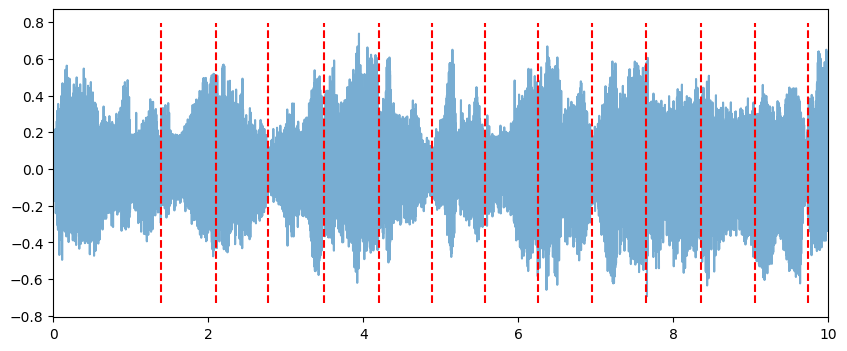

In [146]:
def plot_dynamic_programming(c_score, backlink, ose, beats):
    # Plot the cumulative score and onset strength envelope
    plt.figure(figsize=(14, 6))
    plt.plot(ose, label='Onset Strength Envelope', color='blue', alpha=0.5)
    plt.plot(c_score, label='Cumulative Score', color='orange', alpha=0.8)

    # Add arrows for backlinks
    for i in range(1, len(c_score)):
        if backlink[i] != -1:
            plt.annotate('', xy=(i, c_score[i]), xytext=(backlink[i], c_score[backlink[i]]),
                        arrowprops=dict(arrowstyle="<-", color='gray', alpha=0.5))

    # Highlight the beats
    plt.scatter(beats, c_score[beats], color='red', zorder=5, label='Beats')

    plt.title('Dynamic Programming Beat Tracking Visualization')
    plt.xlabel('Time (frames)')
    plt.ylabel('Score')
    plt.legend()
    plt.grid(True)
    plt.show()

# ported from ellis matlab code
def beat_track(ose, tempo_estimate, sr, alpha=680, hop_sec=0.004, show=False):
    # initialize backlink and cumulative score arrays
    backlink = -np.ones(len(ose), dtype=int)
    c_score = ose.copy()
    
    # define search range for previous beat based on the period
    prev_range = np.arange(-2*tempo_estimate, -round(tempo_estimate/2), dtype=int)
    
    # calculate transition cost using a log-gaussian window over the search range
    cost = -alpha * np.abs(np.log(prev_range / -tempo_estimate) ** 2)

    # set up the dynamic programming loop range
    loop_start = max(-prev_range[0], 0)
    loop_end = len(ose)
    
    # use the loop to fill in backlink and cumlative score
    for i in range(loop_start, loop_end):
        timerange = i + prev_range
        # ensure timerange indices are within bounds
        valid_timerange = timerange[(timerange >= 0) & (timerange < len(ose))]
        if len(valid_timerange) == 0:
            continue  # skip if no valid timerange
        
        # calculate score candidates and find the best predecessor beat
        score_candiadates = cost[:len(valid_timerange)] + c_score[valid_timerange]
        max_score_index = np.argmax(score_candiadates)
        max_score = score_candiadates[max_score_index]
        
        # update cumulative score and backlink
        c_score[i] = max_score + ose[i]
        backlink[i] = valid_timerange[max_score_index]
    
    # start backtrace from the highest cumulative score
    beats = [np.argmax(c_score)]
    
    # backtrace to find all predecessors
    while backlink[beats[0]] > 0:
        beats.insert(0, backlink[beats[0]])
    
    hop_length = int(hop_sec * sr)
    times = librosa.frames_to_time(beats, sr=sr, hop_length=hop_length)
    
    if(show): plot_dynamic_programming(c_score, backlink, ose, beats)
    
    return times

beats_estimates = beat_track(ose, tempo_estimate, sr, hop_sec=hop_sec)
hop_length = int(hop_sec * sr)

print(len(beats_estimates))
print(beats_estimates)

x_lim = [0, 10]

plt.figure(figsize=(10, 4))
plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
plt.vlines(beats_estimates, ymin=min(y), ymax=max(y), color='r', linestyle='--', label='Onsets')  # plot beats
plt.xlim(x_lim)

# librosa to compare
# tempo, beats = librosa.beat.beat_track(y=y, sr=sr)
# beat_times = librosa.frames_to_time(beats, sr=sr) # to get times from frames

# plt.figure(figsize=(10, 4))
# plt.plot(np.linspace(0, (len(y) / sr), num=len(y)), y, alpha=0.6)  # plot waveform
# plt.vlines(beat_times, ymin=min(y), ymax=max(y), color='r', linestyle='--', label='Onsets')  # plot beats
# plt.title('Beat tracking - BPM: {}'.format(tempo))
# plt.xlim(x_lim)


# Evaluation

In [149]:
from mir_eval import beat as beats_eval

def evaluation(beats_ref, beats_est, trim=False):
    if trim: 
        beats_ref = beats_eval.trim_beats(beats_ref)
        beats_est = beats_eval.trim_beats(beats_est)
    
    f_measure = beats_eval.f_measure(beats_ref, beats_est)
    cemgil = beats_eval.cemgil(beats_ref, beats_est)
    goto = beats_eval.goto(beats_ref, beats_est)
    # p_score = beats_eval.p_score(beats_ref, beats_est) broken: numpy depricated int error in mir_eval lib
    continuity = beats_eval.continuity(beats_ref, beats_est)
    information_gain = beats_eval.information_gain(beats_ref, beats_est)
    
    return {
        "f_measure": f_measure, 
        "cemgil": cemgil,
        "goto": goto,
        #"p_score": p_score, 
        "continuity": continuity, 
        "information_gain": information_gain 
    }

#  "data/BallroomAnnotations/Albums-Ballroom_Classics4-20.beats"

beats_location = "data/BallroomAnnotations/Albums-Ballroom_Classics4-20.beats"
beats_file = open(beats_location, 'r')
beats_lines = beats_file.readlines()
beats_reference = np.array([])

for line in beats_lines:
    line_arr = line.split(" ")
    beat = line_arr[0]
    # bar = line_arr[1] if == 1 for downbeat
    beats_reference = np.append(beats_reference, float(beat))

scores = evaluation(beats_reference, beats_estimates)

print(scores)

{'f_measure': 0.6987951807228916, 'cemgil': (0.4477871629044297, 0.4477871629044297), 'goto': 0.0, 'continuity': (0.8571428571428571, 0.8571428571428571, 0.8571428571428571, 0.8571428571428571), 'information_gain': 0.34693190278877223}


# Testing on full dataset

In [ ]:
# class Song
    # audio file
    # reference file
    # beats_reference
    # beats_estimate
    # evaluation

# for each file in data set - only take a subset since whole = 1 Gb?
 # get audio file location
 # get beat reference location
 # evaluate

# run evaluation of results
 # total accuracy - which measure is best ?
 
# evaluate different free variables